___
# BE CAREFUL - in alpha development, no effort is  made at all to avoid sequence issues i.e., it's your responsibility to execute the code cells in the right sequence - the intended order of execution is the from start to end of this document

Also, the accompanying text is rudimentary - this is not yet meant to be distribution ready, it is at the request of students that this is being distributed

The code contained herein produces some figures similar to those presented in the LSM lecture notes

Semme J. Dijkstra. 2023/4/19
___

The convergence criterion - once the previous estimate differs from the current by less than this amount we deem the problem solved. Note that  this value arrived at by experience and is often chosen to be one order of
% magnitude lower than the desired resolution of the estimate of the unknown - it may that that is  unrealistically low, in which case the correction vector $\hat{\vec\delta}$ (`del`) starts overshooting and thus the estimate $\hat{\vec{x}}$ (`x_e`) for $\vec{x}$ (`x`) starts dithering - we may recognize this happening when the magnitude of the correction vector stabilizes or gets larger.

Thus to check for convergence we normally will continue until the solution starts to dither. If this does not happen then we check for the convergence criterion. We expect that normally the solution will converge after 3 iterations, so we will start checking for the convergence criterion after 6.

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, diag, pi, sin, cos
from numpy.linalg import inv, det, pinv, eig
from scipy.stats.distributions import chi2

# Initialization functions with qualitative descriptors


def get_geometry(geometry='good'):
    if geometry.lower() == 'bad':
        xb = np.array([[2, 5, 4], [1, 4, 3]])
    elif geometry.lower() == 'good':
        xb = np.array([[0, 2, 4], [0, 3, 1]])
    else:
        raise Runtimeerror(
            'Invalid geometry option %s must be \'bad\' or \'good\')' % geometry.lower())
    return xb

# Observation quality is usually specified as fixed quantity (sd_l_fix; instrument noise) + a range
# dependent quantity (sd_l_obs; msmt noise)


def get_obs_quality(obs_qual='good'):
    if obs_qual.lower() == 'bad':
        sd_l_fix = .1
        sd_l_obs = .05
    elif obs_qual.lower() == 'good':
        sd_l_fix = .01
        sd_l_obs = .005
    else:
        raise Runtimeerror(
            'Invalid obs_qual option %s must be \'bad\' or \'good\')' % obs_qual.lower())
    return sd_l_fix, sd_l_obs


def get_estimate_x(estimate_x='good'):
    if estimate_x.lower() == 'bad':
        x_e = np.array([[2.5], [.5]])
    elif estimate_x.lower() == 'really bad':
        x_e = np.array([[2.5], [1.5]])
    elif estimate_x.lower() == 'good':
        x_e = np.array([[1.9], [1.9]])
    else:
        raise Runtimeerror(
            'Invalid estimate_x option %s must be \'bad\' or \'good\')' % estimate_x.lower())
    return x_e


# Quantitative Initialization parameters

u = 2   # The dimensions of unknown 𝑥⃗ i.e., the unknowns u
n = 3   # The number of observations
c_i_pct = 95  # The desired percentage confidence interval

# The true value of 'unknown' point 𝑥⃗
x = np.array([2, 2]).reshape(2, 1)

# Convergence criterion
conv_delta = 0.0001

# Max iterations
max_iter = 10

# Qualitative Initialization parameters

xb = get_geometry(geometry='good')                     # ['bad', 'good'], quality of observations
sd_l_fix, sd_l_obs = get_obs_quality(obs_qual='bad')  # ['bad', 'good'], quality of Geometry
x_e = get_estimate_x(estimate_x='really bad')         # ['really bad', 'bad', 'good'], quality of  𝑥⃗ ̂
x_0 = x_e


In [101]:
# Functions needed

# Plot ranging LOPs centered on xb, at range l, using shape s 
def plot_ranging_geometry(xb,l,s = '-', label = '', plot_base = False):
    t = np.linspace(0,2*pi,120)
    x = np.array([cos(t),sin(t)])

    for i in range(len(l)):
        if plot_base:
            plt.plot(xb[0,i],xb[1,i],'.',color = 'C'+str(i), label = 'Base: ' + str(i))
        plt.plot(xb[0,i] + l[i]*x[0],xb[1,i]+l[i]*x[1],s,color = 'C'+str(i), label = label + str(i))
    return

Setting the `obs_qual` to `'good'` and the `estimate_x` to `'really bad'` illustrates that good quality instruments cannot overcome bad experimental design! 

Only with the bad initial estimate  $\hat{\vec{x}}_0$ (`estimate_x`) of $\vec{x}$ (`x`) will the analysis of the covariance indicate that we are in a worse situation than with the good initial estimate - this because it is chosen to lead to a singular $\mat{C}x$ with the really bad initial estimate it all comes up as if the solutions are as valid as with the good estimate i.e., there is no warning that you are doing things incorrectly. $\vec{l^o}$

Note that with bad geometry we are creating a problem in which the set of normal equations $(\mat{A}$


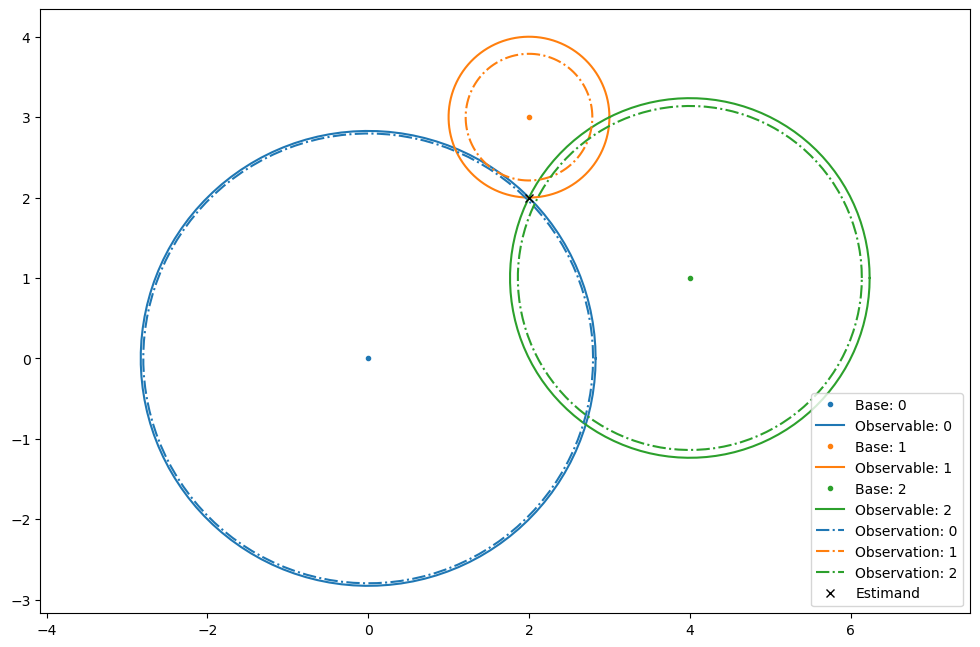

In [102]:
# Preserve the initial estimate

# Synthesize and Plot the observables
# The distances will be the diagonal of the inner product (x-xb)

# The observables
l = sqrt(np.diag((x-xb).T@(x-xb))).reshape(3,1) 

# Create synthetic observations 𝑙𝑜 (lo) from the observables 𝜎𝑙𝑓𝑖𝑥
lo = l+np.random.normal(0,sd_l_fix + sd_l_obs,(n,1))

# Plot the geometry, the observables and the observations
# For now this relies on the appropraite plot gca being active!

fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')

plot_ranging_geometry(xb,l,'-','Observable: ', True)
plot_ranging_geometry(xb,lo,'-.','Observation: ')
plt.axis('equal')
plt.plot(x[0],x[1], 'xk', label = 'Estimand')
plt.legend()
plt.show()

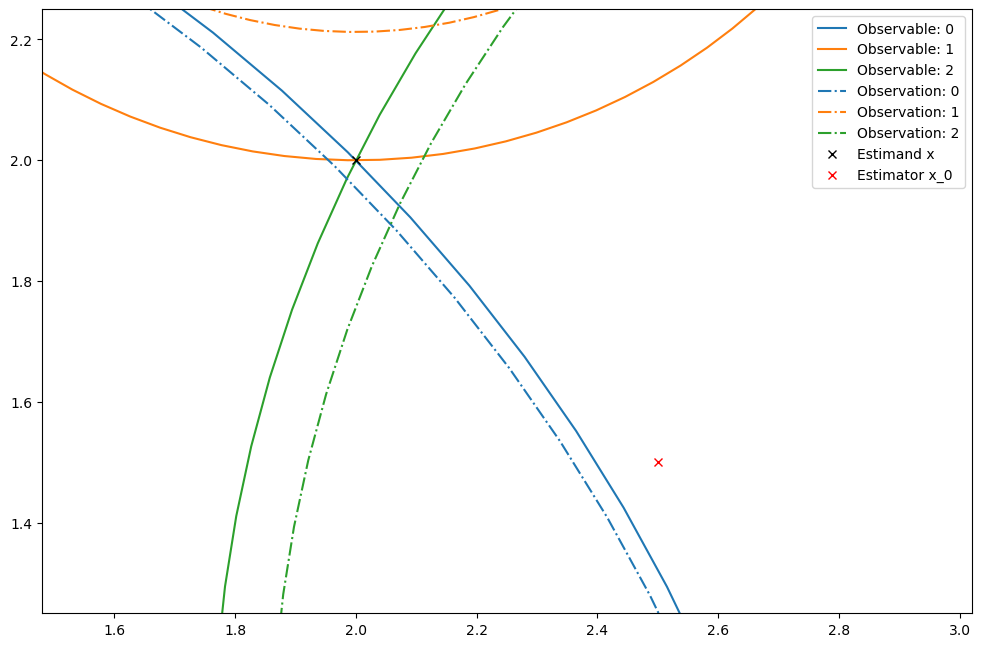

In [103]:
# Now that we have an overview plot zoom in on the area of the observant and initial estimate

error = x - x_0
x_m = (x + x_0)/2
lim = np.hstack((x_m - abs(error),x_m + abs(error)))


fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plot_ranging_geometry(xb,l,'-','Observable: ')
plot_ranging_geometry(xb,lo,'-.','Observation: ')

plt.plot(x[0],x[1], 'xk', label = 'Estimand x')
plt.plot(x_0[0],x_0[1], 'xr', label = 'Estimator x_0')
plt.legend()
plt.axis('equal')
plt.xlim(lim[0])
plt.ylim(lim[1])

plt.show()

Since we don't know the observables it may be more informative to plot the observations `lo` together with the observations that we may model for `x_0`


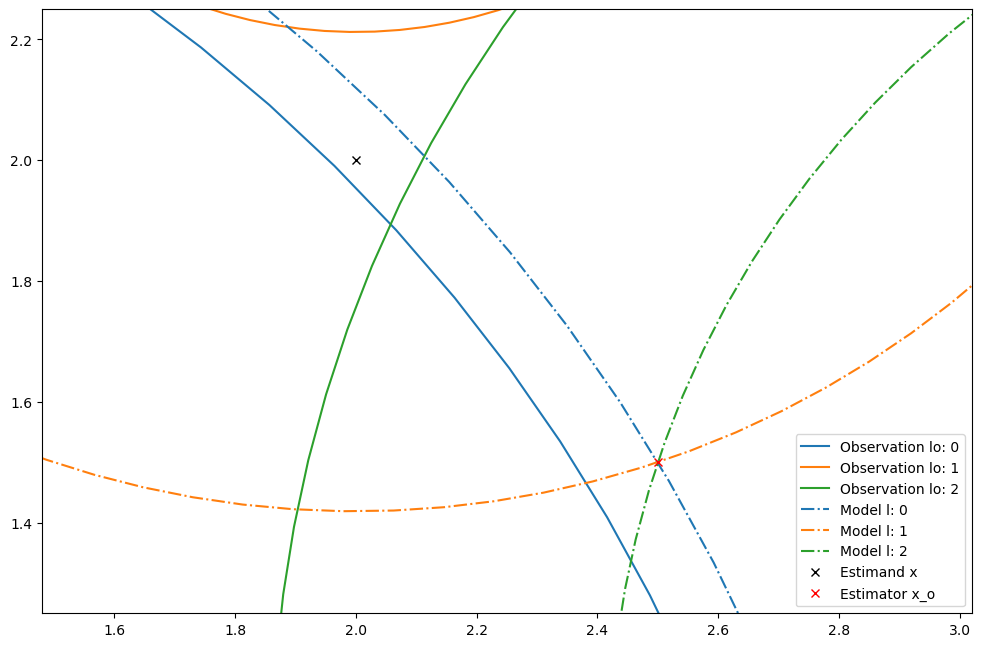

In [104]:
# Now that we have an overview plot zoom in on the area of the observant and initial estimate
error = x - x_0
x_m = (x + x_0)/2
extent = (x_m - abs(error),x_m + abs(error))
lim = np.hstack(extent)

lm = sqrt(np.diag((x_0-xb).T@(x_0-xb))).reshape(3,1) 


fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plot_ranging_geometry(xb,lo,'-','Observation lo: ')
plot_ranging_geometry(xb,lm,'-.','Model l: ')

plt.plot(x[0],x[1], 'xk', label = 'Estimand x')
plt.plot(x_0[0],x_0[1], 'xr', label = 'Estimator x_o')
plt.legend()
plt.axis('equal')
plt.xlim(lim[0])
plt.ylim(lim[1])

plt.show()

We can plot the model lines `Ax` through x 

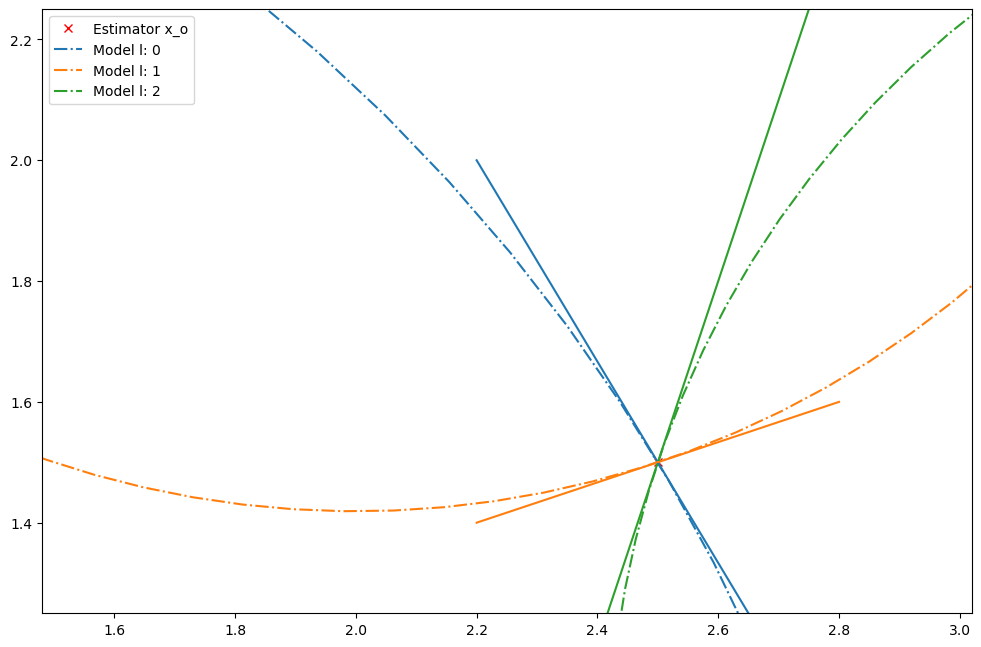

In [105]:
# We know everything about the geometry, we may calculate the initial design matrix A
# We do this by taking the derivative of the ranging equations at `x_0`
# We can now show the linear approximations at the location `x_0`

# The design at `x_0`
A = ((x_0 - xb)/lm.T).T

# # The design at x i.e., the unknown truth
# At = ((x - xb)/l.T).T

fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(x_0[0],x_0[1], 'xr', label = 'Estimator x_o')

# Calculate the linearized lops at a small interval
t = np.array([x_0[0] -.3, x_0[0], x_0[0] +.3])
xl = np.zeros((2,3*len(l)))
offset = np.zeros(3)
for i in range(len(l)):
    for j in range(3):
        ii = 3 * i + j
        xl[0,ii] = t[j]
        xl[1,ii] = (lo[i]-A[i,0]*t[j])/A[i,1]
        
    offset[i] = x_0[1]-xl[1,3*i+1]
    
    plt.plot(xl[0,3 * i:3 * i+3],xl[1,3 * i:3 * i+3]+offset[i])

plot_ranging_geometry(xb,lm,'-.','Model l: ')

plt.legend()
plt.axis('equal')
plt.xlim(lim[0])
plt.ylim(lim[1])

plt.show()

The model lines are not exactly parallel to the observables, they will become more so as the estimate is refined

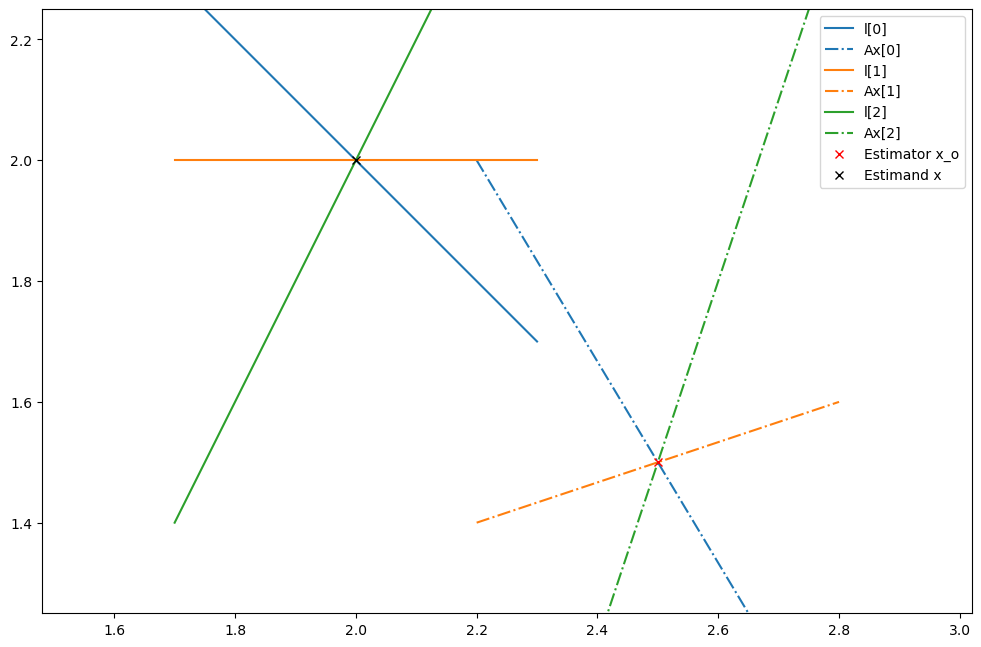

In [106]:
# We can illustrate the difference with the true location x

# The design at `x_0`
Ax = ((x - xb)/l.T).T

fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')


# Calculate the linearized lops at a small interval
t = np.array([x[0] -.3, x[0], x[0] +.3])
xlt = np.zeros((2,3*len(l)))
for i in range(len(l)):
    for j in range(3):
        ii = 3 * i + j
        xlt[0,ii] = t[j]
        xlt[1,ii] = (l[i]-Ax[i,0]*t[j])/Ax[i,1]
        
    offset_t = x[1]-xlt[1,3*i+1]
    plt.plot(xlt[0,3 * i:3 * i+3],xlt[1,3 * i:3 * i+3]+offset_t,'-',label = 'l['+str(i)+']', color = 'C'+str(i))
    plt.plot(xl[0,3 * i:3 * i+3],xl[1,3 * i:3 * i+3]+offset[i],'-.',label = 'Ax['+str(i)+']', color = 'C'+str(i))


plt.plot(x_0[0],x_0[1], 'xr', label = 'Estimator x_o')
plt.plot(x[0],x[1], 'xk', label = 'Estimand x')
# # plt.plot(x_0[0],x_0[1], 'xr', label = 'Estimator x_o')
# # plt.plot(xl[0],xl[1])

plt.legend()
plt.axis('equal')
plt.xlim(lim[0])
plt.ylim(lim[1])

plt.show()

Iterated 5 times to converge to solution of `x_e`
[[2.04693125]
 [2.1153902 ]]


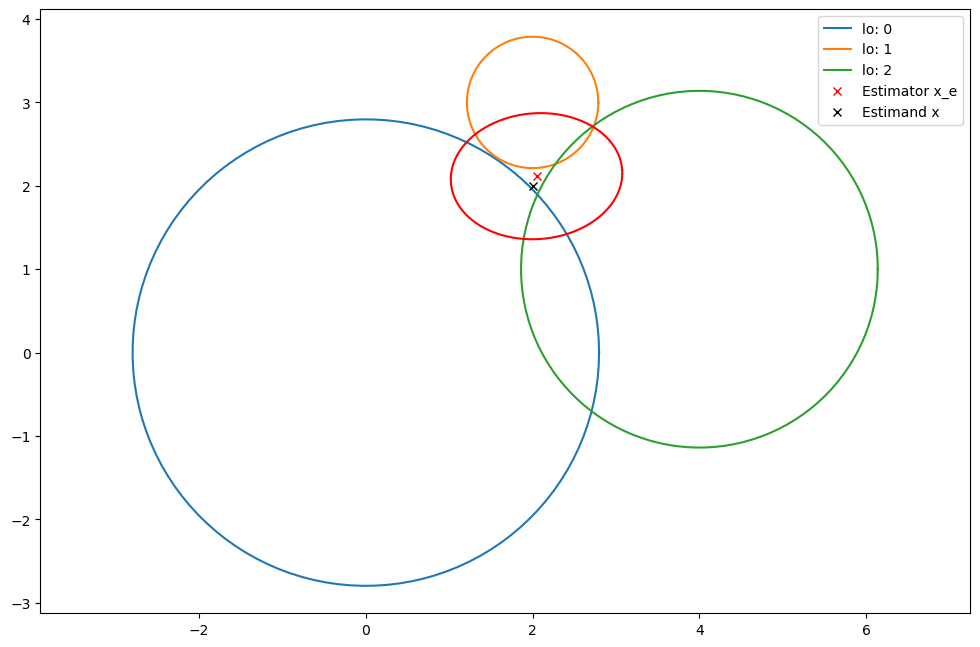

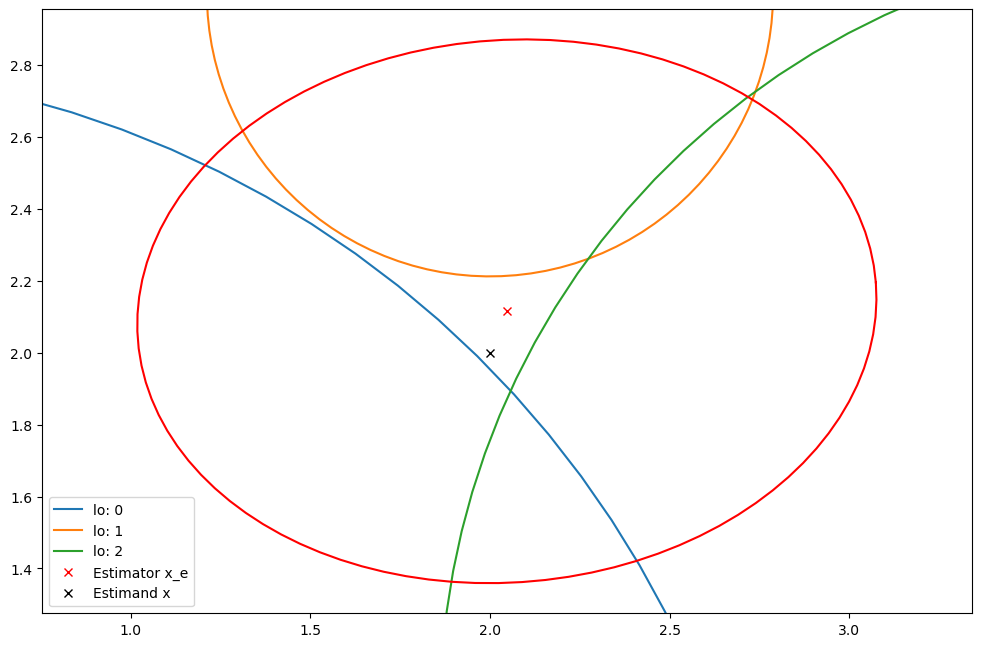

In [108]:
# We can now solve the problem

# Get the Observation uncertainty - we will assume no correlation between the observations
Cl = (sd_l_fix + sd_l_obs*lo)*np.eye(len(lo))

P = inv(Cl)

# Make sure that the estimate `x_e` is equal to `x_0`
x_e = x_0.copy()

# iterate until we converge on a solution

delta_list = []
x_e_list = [x_e]
i = 0
while True:
    
    # The modeled observations
    lm = sqrt(np.diag((x_e-xb).T@(x_e-xb))).reshape(3,1) 
    
    # The misclosures `w`
    w = lm - lo    
    
    # The design at 'x_e' for ranging observations
    A = ((x_e - xb)/lm.T).T
    
    # The Covariance matrix `Cx` of `x` and `delta`
    # Solved using the pseudo-inverse rather than than the regular inverse as we, deliberately, will often
    # have near singular or singular problems
    Cx = pinv(A.T@P@A)
    
    # The adjustment vector `delta`
    delta = -Cx@A.T@P@w
    delta_list.append(delta)
    
    # Update the estimate
    x_e += delta 
    x_e_list.append(x_e)
    
    
    # We are done operations - clean up
    i += 1
    
    if i > max_iter:
        print('Iterated %d times without converging, aborting estimation of x_e'%i)
        x_e = np.nan
        break
        
    if sqrt(delta.T@delta) < conv_delta:
        print('Iterated %d times to converge to solution of `x_e`'%i)
        print(x_e)
        break
        
# Determine the Eigenvalues d and Eigenvectors V of Cx
d, V = eig(Cx)

# Set the desired confidence interval (as a fraction [0,1], rather than a percentage)
c_int = 95/100

# Determine the k^2 value associated to the chosen confidence interval
k_2 = chi2.ppf(c_int, df = 2)

# Create an ellipse using a parametric representation
t = np.linspace(0,2*pi, 100)
locus = V@np.stack((sqrt(d[0]*k_2)*cos(t),sqrt(d[1]*k_2)*sin(t)))+x_e



        
# We can now plot 
fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plot_ranging_geometry(xb,lo,'-','lo: ')
plt.plot(x_e[0],x_e[1], 'xr', label = 'Estimator x_e')
plt.plot(x[0],x[1], 'xk', label = 'Estimand x')
plt.plot(locus[0,:],locus[1,:],'r')
plt.legend()
plt.axis('equal')


# Zoom in on the area of uncertainty
if Cx[0,0]>Cx[1,1]:
    dev = sqrt(Cx[0,0])
else:
    dev = sqrt(Cx[1,1])
lim = np.hstack((x_e - 2*dev,x_e + 2*dev))
    
fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plot_ranging_geometry(xb,lo,'-','lo: ')
plt.plot(x_e[0],x_e[1], 'xr', label = 'Estimator x_e')
plt.plot(x[0],x[1], 'xk', label = 'Estimand x')
plt.plot(locus[0,:],locus[1,:],'r')
plt.axis('equal')
plt.xlim(lim[0])
plt.ylim(lim[1])
plt.legend()
plt.show()